<a href="https://colab.research.google.com/github/guidenis93/A-Student-Guide-to-Bayesian-Statistics/blob/main/Problem_set_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Models

In [127]:
import numpy as np
import pandas as pd
import pystan
import io
import plotnine
from plotnine import *
import arviz as az

from google.colab import files
# uploaded = files.upload()

In [85]:
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Mortality treated
df["m_treated"] = df["rt"] / df["nt"]

# Mortality control
df["m_control"] = df["rc"] / df["nc"]

# Rename first column
df.columns.values[0] = "study"

df.head()

,study,rt,nt,rc,nc,N,m_treated,m_control
0,1,3,38,3,39,22,0.078947,0.076923
1,2,7,114,14,116,22,0.061404,0.120690
2,3,5,69,11,93,22,0.072464,0.118280
3,4,102,1533,127,1520,22,0.066536,0.083553
4,5,28,355,27,365,22,0.078873,0.073973


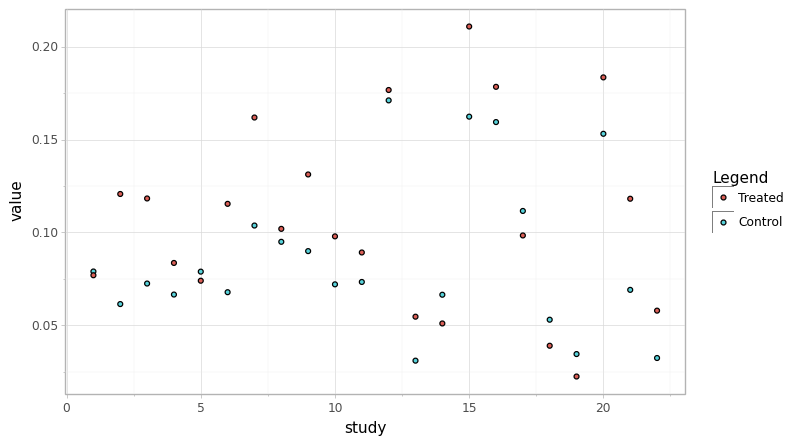

<ggplot: (8774516589365)>

In [87]:
# Plotnine graphic
df_melt = pd.melt(df, id_vars  = "study", value_vars = ["m_treated", "m_control"])

plotnine.options.figure_size = (8, 5)

(ggplot(df_melt, aes(x = "study", y = "value", fill = "variable")) +
 geom_point() +
 scale_fill_discrete(labels = ["Treated", "Control"]) +
 guides(fill=guide_legend(title="Legend")) +
 theme_light()
 )

## Heterogenous model

In [97]:
het_model = """ data {
  int<lower=0> N;
  int<lower=0> nt[N];
  int<lower=0> rt[N];
  int<lower=0> nc[N];
  int<lower=0> rc[N];
}

parameters {
  vector[N] mu;
  vector[N] delta;
}

model {
  rt ~ binomial_logit(nt, mu + delta); //likehood treated
  rc ~ binomial_logit(nc, mu);         //likehood control

  mu ~ normal(0,10);  //prior
  delta ~ normal(0, 10);  //prior
}
"""


In [98]:
# Data
study_data = {"N": df.shape[0], 
              "rt": list(df["rt"]),
              "nt": list(df["nt"]),
              "rc": list(df["rc"]),
              "nc": list(df["nc"])}

# run STAN model
sm = pystan.StanModel(model_code = het_model)
fit = sm.sampling(data = study_data, iter=1000, chains=4, seed=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_aca867e2349573f25c051ee8ca470ae0 NOW.


In [108]:
df_fit = fit.to_dataframe()
print(fit)

Inference for Stan model: anon_model_aca867e2349573f25c051ee8ca470ae0.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -2.65    0.01   0.65  -4.08  -3.04   -2.6  -2.16  -1.57   1857    1.0
mu[2]      -2.02  5.9e-3   0.29  -2.64   -2.2  -2.01  -1.82  -1.47   2436    1.0
mu[3]      -2.05  5.2e-3   0.32  -2.69  -2.26  -2.04  -1.84  -1.46   3760    1.0
mu[4]       -2.4  1.8e-3   0.09  -2.59  -2.46   -2.4  -2.34  -2.22   2912    1.0
mu[5]      -2.55  4.4e-3   0.21  -2.98  -2.69  -2.54   -2.4  -2.14   2257    1.0
mu[6]      -2.11  8.9e-3   0.46  -3.08  -2.41  -2.08  -1.79  -1.28   2635    1.0
mu[7]      -1.65  1.9e-3   0.09  -1.83  -1.71  -1.65  -1.59  -1.48   2144    1.0
mu[8]      -2.18  2.7e-3   0.15  -2.48  -2.28  -2.18  -2.08  -1.89   3102    1.0
mu[9]       -1.9  3.4e-3   0.18  -2.27  -2.01   -1.9  -1.78  -1.57   2810    1.0
mu[

/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:496: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_posterior, generating only 40 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf88e72890>,
      dtype=object)

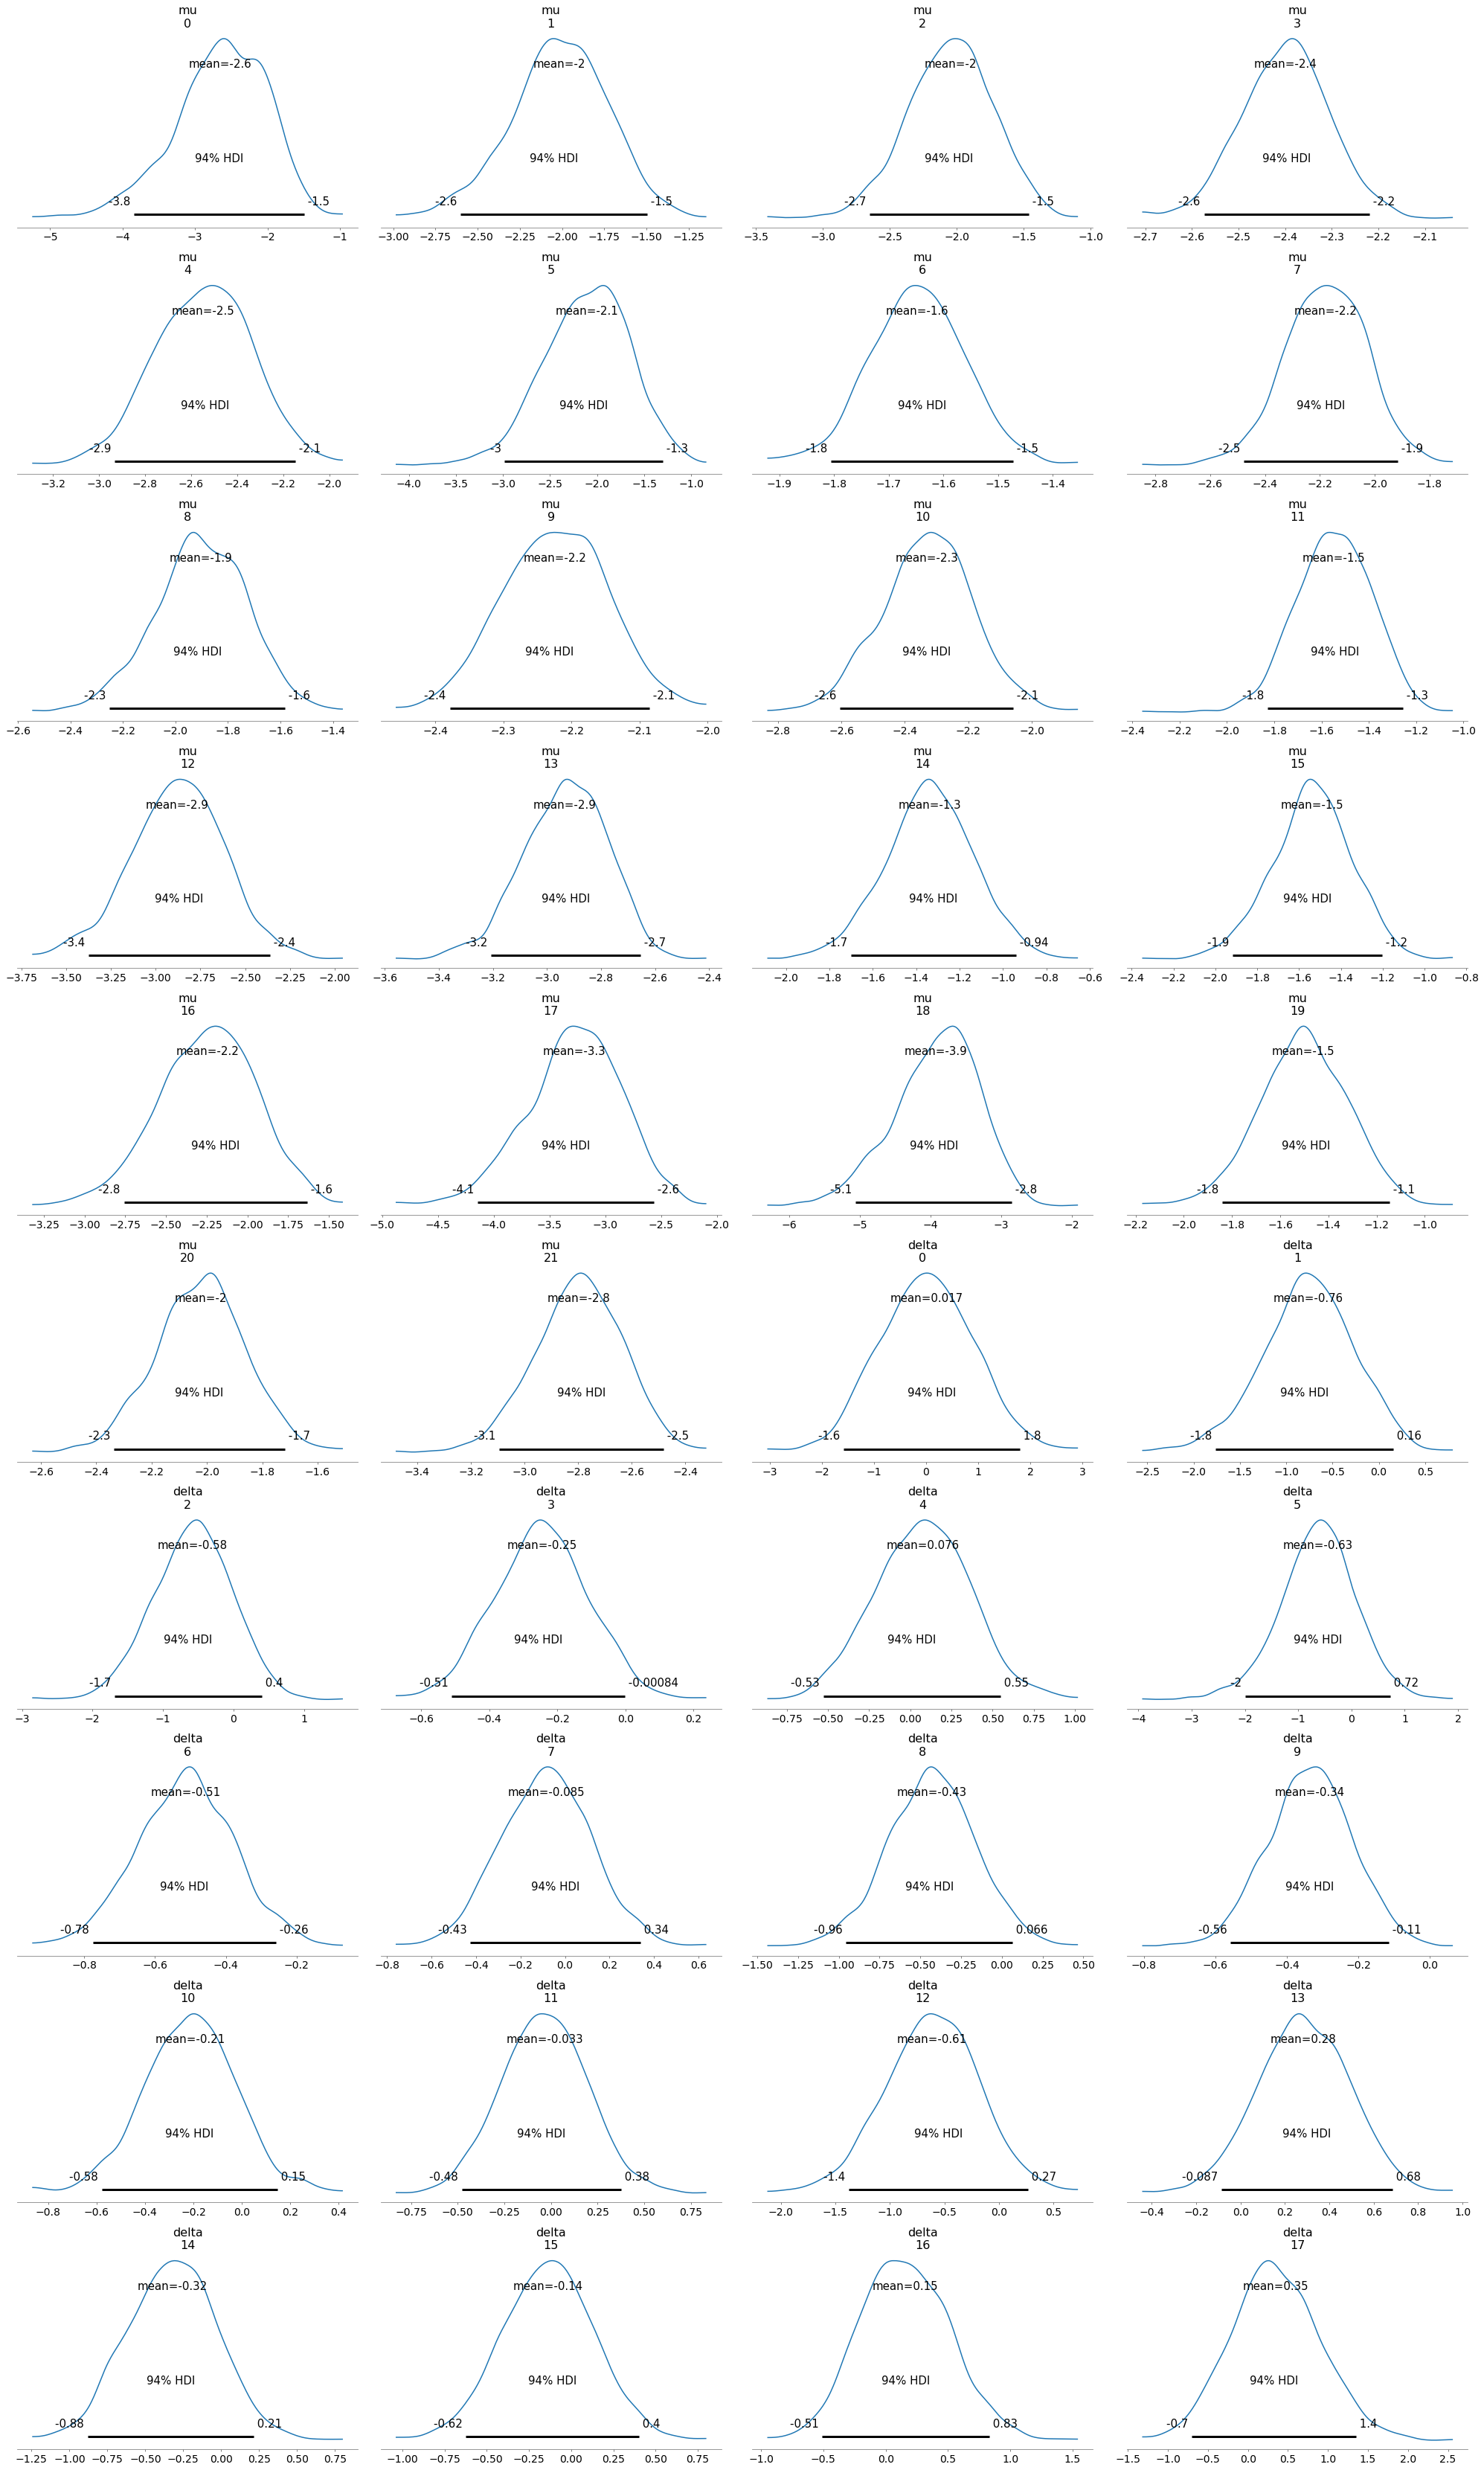

In [133]:
az.plot_posterior(fit)

## Hierarchical model

In [145]:
hier_model = """ data {
  int<lower=0> N;
  int<lower=0> nt[N];
  int<lower=0> rt[N];
  int<lower=0> nc[N];
  int<lower=0> rc[N];
}

parameters {
  vector[N] mu;
  vector[N] delta;
  real d;
  real <lower=0> sigma;
}

model {
  rt ~ binomial_logit(nt, mu + delta); //likehood treated
  rc ~ binomial_logit(nc, mu);         //likehood control

  mu ~ normal(0,10);  //prior
  delta ~ normal(d, sigma);  //prior

  d ~ normal(0, 10);  //hyperpriors
  sigma ~ cauchy(0, 10); //hyperpriors
}

generated quantities {
  real delta_new;

  delta_new = normal_rng(d, sigma);
}
"""

In [146]:
sm2 = pystan.StanModel(model_code = hier_model)
fit2 = sm2.sampling(data = study_data, iter=1000, chains=4, seed=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_12cdd3ab31a8903082ae80601c4dcdcb NOW.


In [147]:
fit2

Inference for Stan model: anon_model_12cdd3ab31a8903082ae80601c4dcdcb.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]      -2.43  9.6e-3   0.44  -3.35  -2.71   -2.4  -2.12  -1.63   2129    1.0
mu[2]       -2.2  8.7e-3   0.25   -2.7  -2.37  -2.19  -2.02  -1.74    814    1.0
mu[3]      -2.15    0.01   0.29  -2.75  -2.32  -2.14  -1.95  -1.62    522    1.0
mu[4]      -2.39  3.4e-3   0.09  -2.57  -2.45   -2.4  -2.34  -2.23    625   1.01
mu[5]      -2.41  7.7e-3   0.16  -2.74  -2.52  -2.41   -2.3  -2.08    463   1.01
mu[6]      -2.22  9.1e-3   0.34  -2.91  -2.45   -2.2  -1.99  -1.61   1360    1.0
mu[7]      -1.71  3.3e-3   0.08  -1.86  -1.77  -1.71  -1.65  -1.56    618    1.0
mu[8]      -2.12  3.2e-3   0.12  -2.37   -2.2  -2.12  -2.04  -1.89   1409    1.0
mu[9]      -1.96  4.4e-3   0.15  -2.25  -2.06  -1.97  -1.86  -1.67   1170    1.0
mu[

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 59'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


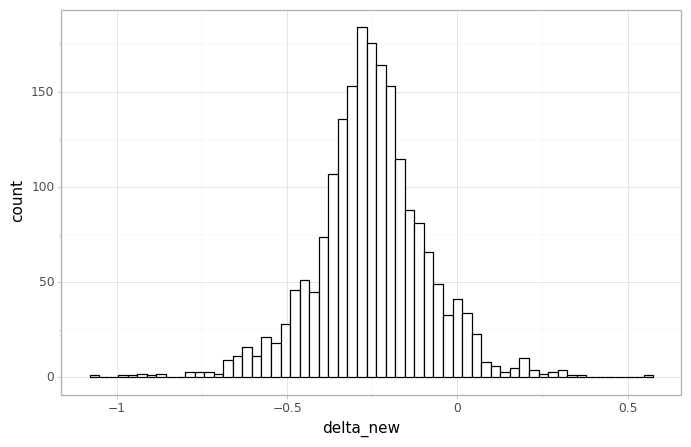

<ggplot: (8774484854705)>

In [161]:
df_fit2 = fit2.to_dataframe()
df_fit2["index"] = df_fit2.index

# Plot graph
plotnine.options.figure_size = (8, 5)

(ggplot(df_fit2, aes(x = "delta_new")) +
 geom_histogram(color = "black", fill = "white") +
 theme_light()
 )